# Distributed Hybrid Plant - Midsize Example

This example is an extension of [Example 08](./08-distributed-residential-example.ipynb). In this example, we consider another distributed wind-hybrid system to supply nearby electrical loads. It highlights various site definition features and their applications in a distributed energy setup. This notebook will guide you through setting up a simulation for a distributed hybrid energy system using HOPP and assess how well the plant design meets the load demand for varying wind and solar resource conditions.

## Hybrid Plant Design

The hybrid plant design in this example includes:
- 5850 kW-DC of rooftop solar-PV **located within the town**
- 25 Vestas V47 turbines **located outside of the town**
  + We selected the "VestasV47_660kW_47" turbine from the turbines available in the [turbine-models library](https://github.com/NREL/turbine-models). The [Vestas V47](https://en.wind-turbine-models.com/turbines/13-vestas-v47) turbine has a rated power of 660 kW and is grouped in the "onshore" category of the turbine-models library. This turbine is used as the [representative technology](https://atb.nrel.gov/electricity/2024/distributed_wind#representative_technology) for the "midsize" scale distributed wind turbine in NREL's Annual Technology Baseline (ATB). 
- A 1 MW battery with 4-hours of storage capacity
  + This battery aligns with the [Commercial Battery Storage](https://atb.nrel.gov/electricity/2024/commercial_battery_storage) representative technology in NREL's ATB.

This plant design is represented under the `technologies` section of the [HOPP config input file](./inputs/09-distributed-wind-solar-midsize.yaml).

### Import required modules

Start by importing the necessary modules and packaged and setting up our working environment.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from floris import TimeSeries
from floris.layout_visualization import plot_turbine_points
from hopp import ROOT_DIR
from hopp.utilities.keys import set_nrel_key_dot_env
from hopp.simulation import HoppInterface
from hopp.utilities.utilities import load_yaml
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)


set_nrel_key_dot_env()

/Users/egrant/Documents/projects/HOPP/examples/log/hybrid_systems_2025-03-20T10.59.37.239340.log


### Load Inputs

Load the configuration YAML file as `hopp_config`.

In [2]:
example_dir = ROOT_DIR.parent / "examples"
input_filepath = os.path.join(str(example_dir),"inputs","09-distributed-wind-solar-midsize.yaml")
hopp_config = load_yaml(input_filepath)

## Wind and Solar Resource Data

Wind resource data is downloaded from [WIND Toolkit](https://developer.nrel.gov/docs/wind/wind-toolkit/wtk-download/), a dataset within the [Wind Resource Database (or WRDB)](https://wrdb.nrel.gov/data-viewer). WIND Toolkit provides wind resource data for resource years 2007-2014.

Solar resource data is downloaded from [National Solar Radiation Database (NSRDB)](https://nsrdb.nrel.gov) and is available for resource years 1998-2022.

### Different Locations for wind and solar resource

In this example, the wind system is not co-located with the rooftop PV system. Therefore, we need to specify different locations for the wind and solar resource. In the configuration input file, we can specify unique locations and resource years for wind and solar resource. 

Wind resource data will be downloaded at the location (`wind_lat`, `wind_lon`) for the resource year `wind_year`. In this example, the wind system is located at (37.7768, -106.033) which is specified in the configuration input file as:

```yaml
site:
  data:
    wind_year: 2013
    wind_lat: 37.7768 
    wind_lon: -106.033 
```

Solar resource data will be downloaded at the location (`solar_lat`, `solar_lon`) for the resource year `solar_year`.  In this example, the rooftop PV system is located at (38.087, -106.1423) which is specified in the configuration input file as:

```yaml
site:
  data:
    solar_year: 2018
    solar_lat: 38.087 
    solar_lon: -106.1423
```

The `site_shape` can be set to values of "hexagon", "circle", "square", or "rectangle". The site area can be defined in either kilometers (with the variable `site_area_km2`) or meters (with the variable `site_area_m2`). The site is defined under the `site` section of the configuration input file as:

```yaml
site:
  data:
    lat: 37.7768
    lon: -106.033
    solar_year: 2018
    solar_lat: 38.087 #for rooftop - center of town
    solar_lon: -106.1423 #for rooftop - center of town
    wind_year: 2013
    wind_lat: 37.7768 #outside of town
    wind_lon: -106.033 #outside of town
    site_details:
      site_shape: "rectangle"
      site_area_km2: 0.80
      aspect_ratio: 3.65
  hub_height: 65 
```

Note that the `hub_height` entry is set to 65 meters because this is one of the hub-heights available for the Vestas V47 wind turbine.

### Run Simulation Across Resource Years

Often resource data can be impactful on simulation results. This example shows how to analyze how different resource data may impact meeting the load. We can simulate the hybrid plant performance by looping through wind and solar resource years and saving results for the percent of load that was missed for each simulation.

Wind resource years must be between 2007 and 2014 for WIND toolkit data, we will simulate just a subset of these years for our analysis. We set the variable `wind_years` as `wind_years = np.arange(2010,2015,2)` which results in wind resource years of 2010, 2012, and 2014.

Solar resource years must be between 1998 and 2022 for NSRDB data, we will simulate just a subset of these years for our analysis. We set the variable `solar_years` as `solar_years = np.arange(2000,2022,5)` which results in solar resource years of 2000, 2005, 2010, 2015, and 2020.

**NOTE**: the below code block takes 3-4 minutes to run.

In [3]:
# set years of wind and solar resource years
wind_years = np.arange(2010,2015,2)
solar_years = np.arange(2000,2022,5)

# initialize an array of zeros that is the shape (3,5)
missed_load_per_year = np.zeros((len(wind_years),len(solar_years)))

# loop through wind years
for wi,wind_year in enumerate(wind_years):
    # update the wind_year in the hopp_config
    hopp_config["site"]["data"]["wind_year"] = wind_year

    # loop through solar years
    for si,solar_year in enumerate(solar_years):
        # update the solar_year in the hopp_config
        hopp_config["site"]["data"]["solar_year"] = solar_year

        # initalize HOPP interface
        hi = HoppInterface(hopp_config)
        # simulate hybrid plant for 1-year
        hi.simulate(project_life = 1)
        #storage the results for the percent of load that was missed
        missed_load_per_year[wi,si] = hi.system.grid.missed_load_percentage


### Visualize the Results

Below is a visualization of the missed load results for each wind and solar resource year combination. In the plot, yellow shading indicates a higher percent of the load is missed and darker green or blue colors indicate that a lower percent of the load is missed. Some findings from these results are:

- A wind resource year of 2014 (the bottom row in the figure below) results in about 5% less missed load than wind resource years of 2010 and 2012. 
- The most missed load (65% missed load) occurs for a wind resource year of 2012 and a solar resource year of 2010. 
- The least missed load (56% missed load) occurs for a wind resource year of 2014 and a solar resource year of 2020. 

From this analysis, we find that wind and solar resource years can change the annual missed load by up to 9% and should consider this uncertainity in future interations of this plant design.

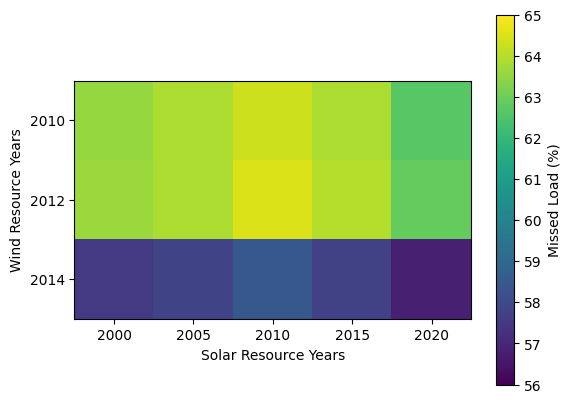

In [4]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    missed_load_per_year, 
    cmap = 'viridis',
    vmin = np.floor(missed_load_per_year.min()),
    vmax = np.ceil(missed_load_per_year.max()),
)
ax.set_xlabel("Solar Resource Years")
ax.set_ylabel("Wind Resource Years")
ax.set_xticks(np.arange(0,len(solar_years),1),solar_years)
ax.set_yticks(np.arange(0,len(wind_years),1),wind_years)
fig.colorbar(im, ax=ax, label = "Missed Load (%)")

### Wind Rose Plot Visualization Using FLORIS

In [Example 08](./08-distributed-residential-example.ipynb) we made a wind rose plot using wind resource data for the *in-town site* and a resource year of 2013 and a hub-height of 24 meters.

In this example, the wind rose plot is made using wind resource data for the *out-of-town site* and a resource year of 2014 (because that was the last wind year we simulated) and a hub-height of 65 meters.

Take a moment to compare the wind rose below to the wind rose in [Example 08](./08-distributed-residential-example.ipynb).


<PolarAxes: >

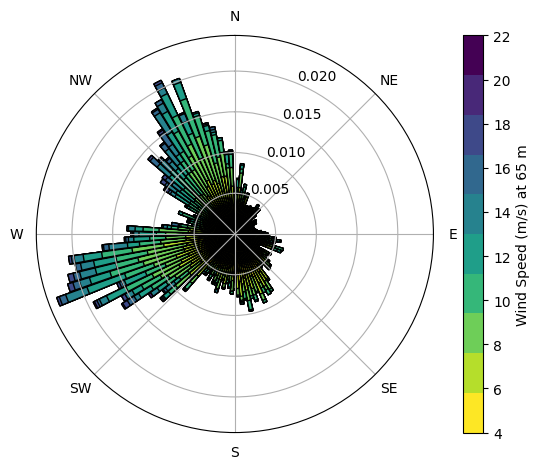

In [5]:
hybrid_plant = hi.system
time_series = TimeSeries(
    wind_directions=hybrid_plant.wind._system_model.wind_dirs[0:8760],
    wind_speeds=hybrid_plant.wind._system_model.speeds[0:8760],
    turbulence_intensities=hybrid_plant.wind._system_model.fi.core.flow_field.turbulence_intensities[0]
)

wind_rose = time_series.to_WindRose(wd_edges=np.arange(0, 360, 3.0), ws_edges=np.arange(2.0, 24.0, 2.0))
fig, ax = plt.subplots(subplot_kw={"polar": True})

hub_ht = int(hybrid_plant.site.wind_resource.hub_height_meters)
wind_rose.plot(ax=ax,legend_kwargs={"label": f"Wind Speed (m/s) at {hub_ht} m"})